In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})
import numpy as np
import pandas as pd
import os
import sys
import cv2
from tqdm.auto import tqdm 
import shutil
from pathlib import Path
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import statistics

In [2]:
base_dir = os.path.join('..', '..')
dataset = 'Dataset'
dataset_dir = os.path.join(base_dir, dataset)
Intermediates_dir = os.path.join('..', 'Intermediates')
Charts_Images_dir = os.path.join(Intermediates_dir, 'Charts_Images')
csv_txt_json_data = os.path.join(Intermediates_dir, 'csv_txt_json_data')

In [46]:
from utils_DP import draw_bbox, plot_multi_imgs, get_bbox_aspect_ratio

In [4]:
df_train = pd.read_csv(os.path.join(csv_txt_json_data, "dataset_after_processing.csv"), index_col= 0)

In [5]:
df_train.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

   x_min  y_min  x_max  y_max  \
0    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN   
2  230.0  458.0  551.0  610.0   
3  421.0  247.0  537.0  339.0   
4    NaN    NaN    NaN    NaN   

                                          image_path  image_height  \
0  ..\..\Dataset\train\train\50a418190bc3fb1ef163...           860   
1  ..\..\Dataset\train\train\21a10246a5ec7af15108...          1053   
2  ..\..\Dataset\train\train\9a5094b2563a1ef3ff50...           778   
3  ..\..\Dataset\train\train\051132a778e61a86eb14...           960   
4  ..\..\Dataset\train\train\063319de25ce7edb9b1c...          1024   

   image_width  bbox_area  bbox_height  bbox_width  bbox_ratio_w/h  xmin_norm  \
0          777        NaN          NaN         NaN             NaN        NaN   
1          984        NaN          NaN         NaN             NaN        NaN   
2          693    48792.0        152.0       321.0           2.112   0.331890   
3          768    10672.0         92.0       116.0           1.261   0.548177   
4          846        NaN          NaN         NaN             NaN        NaN   

   ymin_norm  xmax_norm  ymax_norm  
0        NaN        NaN        NaN  
1        NaN        NaN        NaN  
2   0.588689   0.795094   0.784062  
3   0.257292   0.699219   0.353125  
4        NaN        NaN        NaN

In [6]:
df_finding_train = df_train[df_train.class_id != 14]
df_non_finding_train = df_train[df_train.class_id == 14]

In [38]:
x = df_finding_train[["class_name", "class_id"]].groupby(by = ["class_name", "class_id"]).count().reset_index()
dct_class_ids = {}
for i in x.to_numpy():
  dct_class_ids[i[0]] = int(i[1])
dct_class_ids["No finding"] = 14

def GetKey(val):
   for key, value in dct_class_ids.items():
      if val == value:
        
        return key
      continue
label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100], [0,0,0]]


### 1. Explore image's size

In [8]:
df_train_img_size = df_train[["image_id", "image_height", "image_width"]]

In [9]:
df_train_img_size.head()

image_id  image_height  image_width
0  50a418190bc3fb1ef1633bf9678929b3           860          777
1  21a10246a5ec7af151081d0cd6d65dc9          1053          984
2  9a5094b2563a1ef3ff50dc5c7ff71345           778          693
3  051132a778e61a86eb147c7c6f564dfe           960          768
4  063319de25ce7edb9b1c6b8881290140          1024          846

In [10]:
df_train_img_size = df_train_img_size.groupby(by = "image_id").mean()

In [11]:
df_train_img_size = df_train_img_size.reset_index()

In [12]:
df_train_img_size.shape

(15000, 3)

In [13]:
df_train_img_size.describe()

image_height   image_width
count  15000.000000  15000.000000
mean     928.757467    815.053133
std      100.373880    122.228167
min      309.000000    274.000000
25%      833.000000    682.000000
50%      949.000000    796.000000
75%     1017.000000    890.000000
max     1136.000000   1106.000000

In [14]:
dataset_dir

'..\\..\\Dataset'

In [16]:
train = os.path.join("train", "train")
train_dir = os.path.join(dataset_dir, train)
df_train_img_size["image_path"] = df_train_img_size.image_id.map(lambda x: os.path.join(train_dir, x + ".jpg"))

In [17]:
df_train_img_size.head()

image_id  image_height  image_width  \
0  000434271f63a053c4128a0ba6352c7f           945          778   
1  00053190460d56c53cc3e57321387478           810          664   
2  0005e8e3701dfb1dd93d53e2ff537b6e          1024         1024   
3  0006e0a85696f6bb578e84fafa9a5607          1000         1000   
4  0007d316f756b3fa0baea2ff514ce945           960          768   

                                          image_path  
0  ..\..\Dataset\train\train\000434271f63a053c412...  
1  ..\..\Dataset\train\train\00053190460d56c53cc3...  
2  ..\..\Dataset\train\train\0005e8e3701dfb1dd93d...  
3  ..\..\Dataset\train\train\0006e0a85696f6bb578e...  
4  ..\..\Dataset\train\train\0007d316f756b3fa0bae...

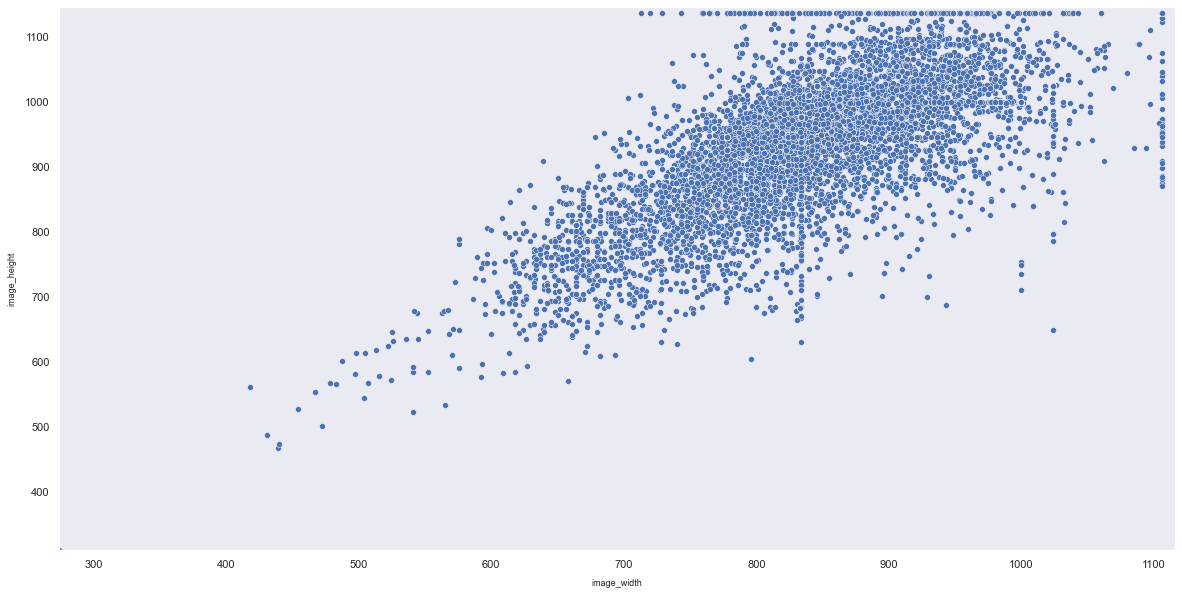

In [18]:
plt.figure(figsize = (20,10))
sns.scatterplot(x = df_train_img_size.image_width, 
                y = df_train_img_size.image_height)
plt.ylim((df_train_img_size.describe()["image_height"]["min"],
          df_train_img_size.describe()["image_height"]["max"]+ 10))

plt.xlim((df_train_img_size.describe()["image_width"]["min"],
          df_train_img_size.describe()["image_width"]["max"]+10))
#plt.savefig(os.path.join(chart_path, "10.Image_size.png"))
plt.show()

+ explore correlation width and height

In [20]:
h = df_train_img_size.image_height.values
w = df_train_img_size.image_width.values
corr, p_value = scipy.stats.pearsonr(h, w) 
print(f"correlation between height and widht of this dataset: {corr} and p-value = {p_value}")

correlation between height and widht of this dataset: 0.7772096853812048 and p-value = 0.0


cause corr > 0.7 --> we can say the height and width have strong positive correlationship

+ explore outlier of image's height and width

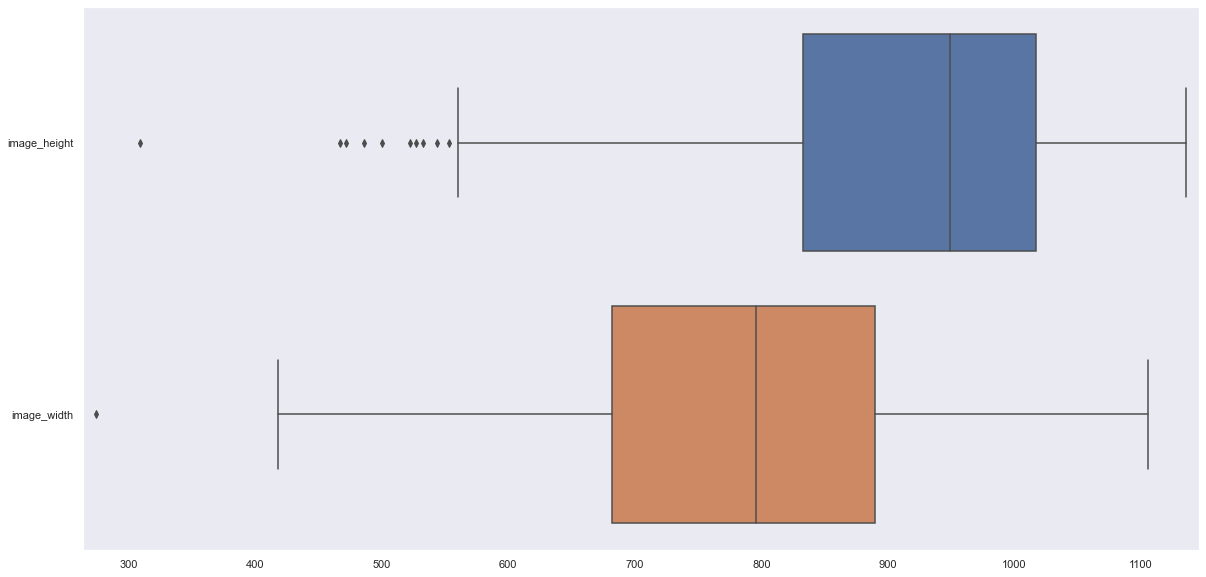

In [21]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_train_img_size, orient= "h")

plt.xlim((df_train_img_size.describe()["image_width"]["min"]-10,
          df_train_img_size.describe()["image_height"]["max"]+10))
#plt.savefig(os.path.join(chart_path, "11.Image_size_box_plot.png"))
plt.show()

+ Outlier min of width and height

In [22]:
iqr_height = scipy.stats.iqr(df_train_img_size.image_height)
iqr_width = scipy.stats.iqr(df_train_img_size.image_width)

In [23]:
Q1_height = df_train_img_size.image_height.quantile(0.25)
Q1_width = df_train_img_size.image_width.quantile(0.25)

In [24]:
number_outlier_min_height = len(df_train_img_size[df_train_img_size.image_height < Q1_height - 1.5*iqr_height])
number_outlier_min_width = len(df_train_img_size[df_train_img_size.image_width < Q1_width - 1.5*iqr_width])
print(f"number_outlier_min_height = {number_outlier_min_height}")
print(f"number_outlier_min_width = {number_outlier_min_width}")

number_outlier_min_height = 10
number_outlier_min_width = 1


+ outlier max of width and height

In [26]:
Q3_height = df_train_img_size.image_height.quantile(0.75)
Q3_width = df_train_img_size.image_width.quantile(0.75)

In [27]:
number_outlier_max_height = len(df_train_img_size[df_train_img_size.image_height > Q3_height + 1.5*iqr_height])
number_outlier_max_width = len(df_train_img_size[df_train_img_size.image_width > Q3_width + 1.5*iqr_width])
print(f"number_outlier_max_height = {number_outlier_max_height}")
print(f"number_outlier_max_width = {number_outlier_max_width}")

number_outlier_max_height = 0
number_outlier_max_width = 0


+ Distribution of image's height and width

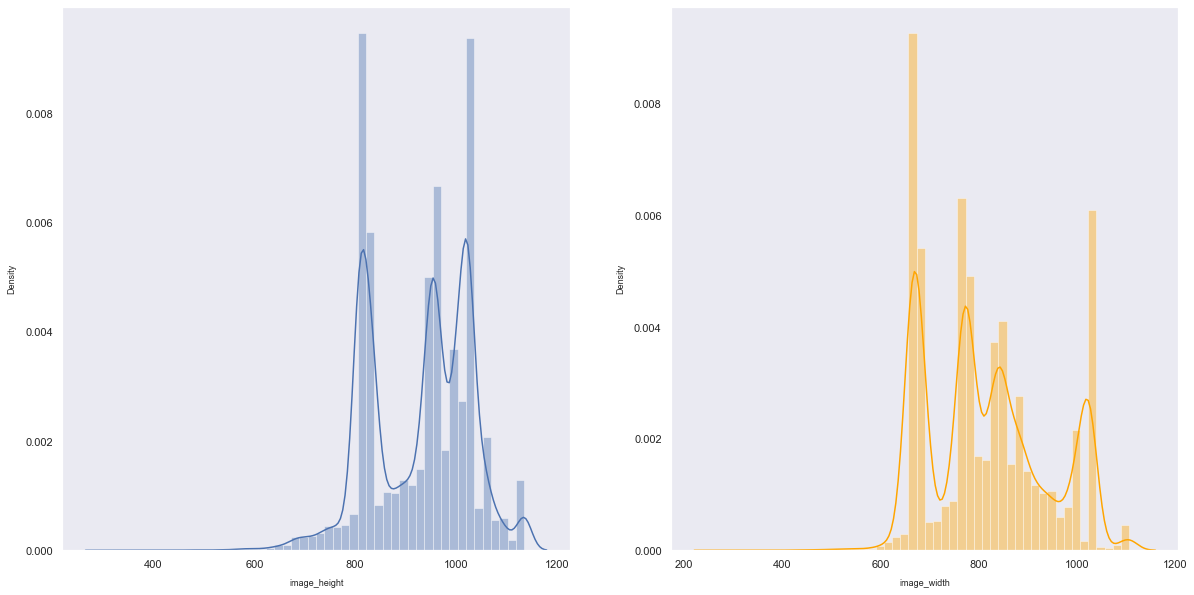

In [30]:
plt.figure(figsize = (20,10))
ax1 = plt.subplot(1,2,1 )
sns.distplot(a = df_train_img_size["image_height"])
ax2 = plt.subplot(1,2,2)

sns.distplot(a = df_train_img_size["image_width"], color = "orange")
#plt.savefig(os.path.join(chart_path, "12.Image_size_dist_plot.png"))
plt.show()

+ display some images with different size

In [41]:
imgs_path = df_train_img_size.image_path.values
thickness =  3
viz_images = []
for img_path in tqdm(imgs_path[3:15], total =len(imgs_path[3:15])):
  img_array = cv2.imread(img_path)
  img_copy = img_array.copy()
  img_id = Path(img_path).stem
  print(img_id)
  boxes_label = df_train.loc[df_train["image_id"] == img_id,["class_id"]].values.squeeze()
  boxes_location = df_train.loc[df_train["image_id"] == img_id,["x_min", "y_min", "x_max", "y_max"]].values  
  print(f"boxes_label \n{boxes_label}")
  
  if len(boxes_location) == 1:
    color = label2color[boxes_label]
    img_copy = draw_bbox(img_copy, 
                    list(np.int_(boxes_location.squeeze())), 
                    GetKey(boxes_label), 
                    color, 
                    thickness = thickness)
  else:
    for label_id, box in zip(boxes_label, boxes_location):
      color = label2color[label_id]
      img_copy = draw_bbox(img_copy, 
                      list(np.int_(box)), 
                      GetKey(label_id), 
                      color, 
                      thickness = thickness)
  viz_images.append(img_copy)


  0%|          | 0/12 [00:00<?, ?it/s]

0006e0a85696f6bb578e84fafa9a5607
boxes_label 
[14 14 14]
0007d316f756b3fa0baea2ff514ce945
boxes_label 
[13 11  3 11 13  0  5  5  0 11 13]
000ae00eb3942d27e0b97903dd563a6e
boxes_label 
[14 14 14]
000d68e42b71d3eac10ccc077aba07c1
boxes_label 
[ 9  9  9  9 11 13 11  0  9  9  7  9  9  9  7  9]
00150343289f317a0ad5629d5b7d9ef9
boxes_label 
[11  0 11 13 10 10 11  9  0  7 10  7 10  3 13 11  0]
00176f7e1b1cb835123f95960b9a9efd
boxes_label 
[14 14 14]
001d127bad87592efe45a5c7678f8b8d
boxes_label 
[13 13  2 13 13 13]
0021df30f3fddef551eb3df4354b1d06
boxes_label 
[14 14 14]
00291f7aff0123ea76a59998effef229
boxes_label 
[14 14 14]
0032c6091dc8f1b1245fc2f5f45458fa
boxes_label 
[14 14 14]
003cfe5ce5c0ec5163138eb3b740e328
boxes_label 
[14 14 14]
0046f681f078851293c4e710c4466058
boxes_label 
[ 0  6 13 11 13 13 13 11 13 13 13]


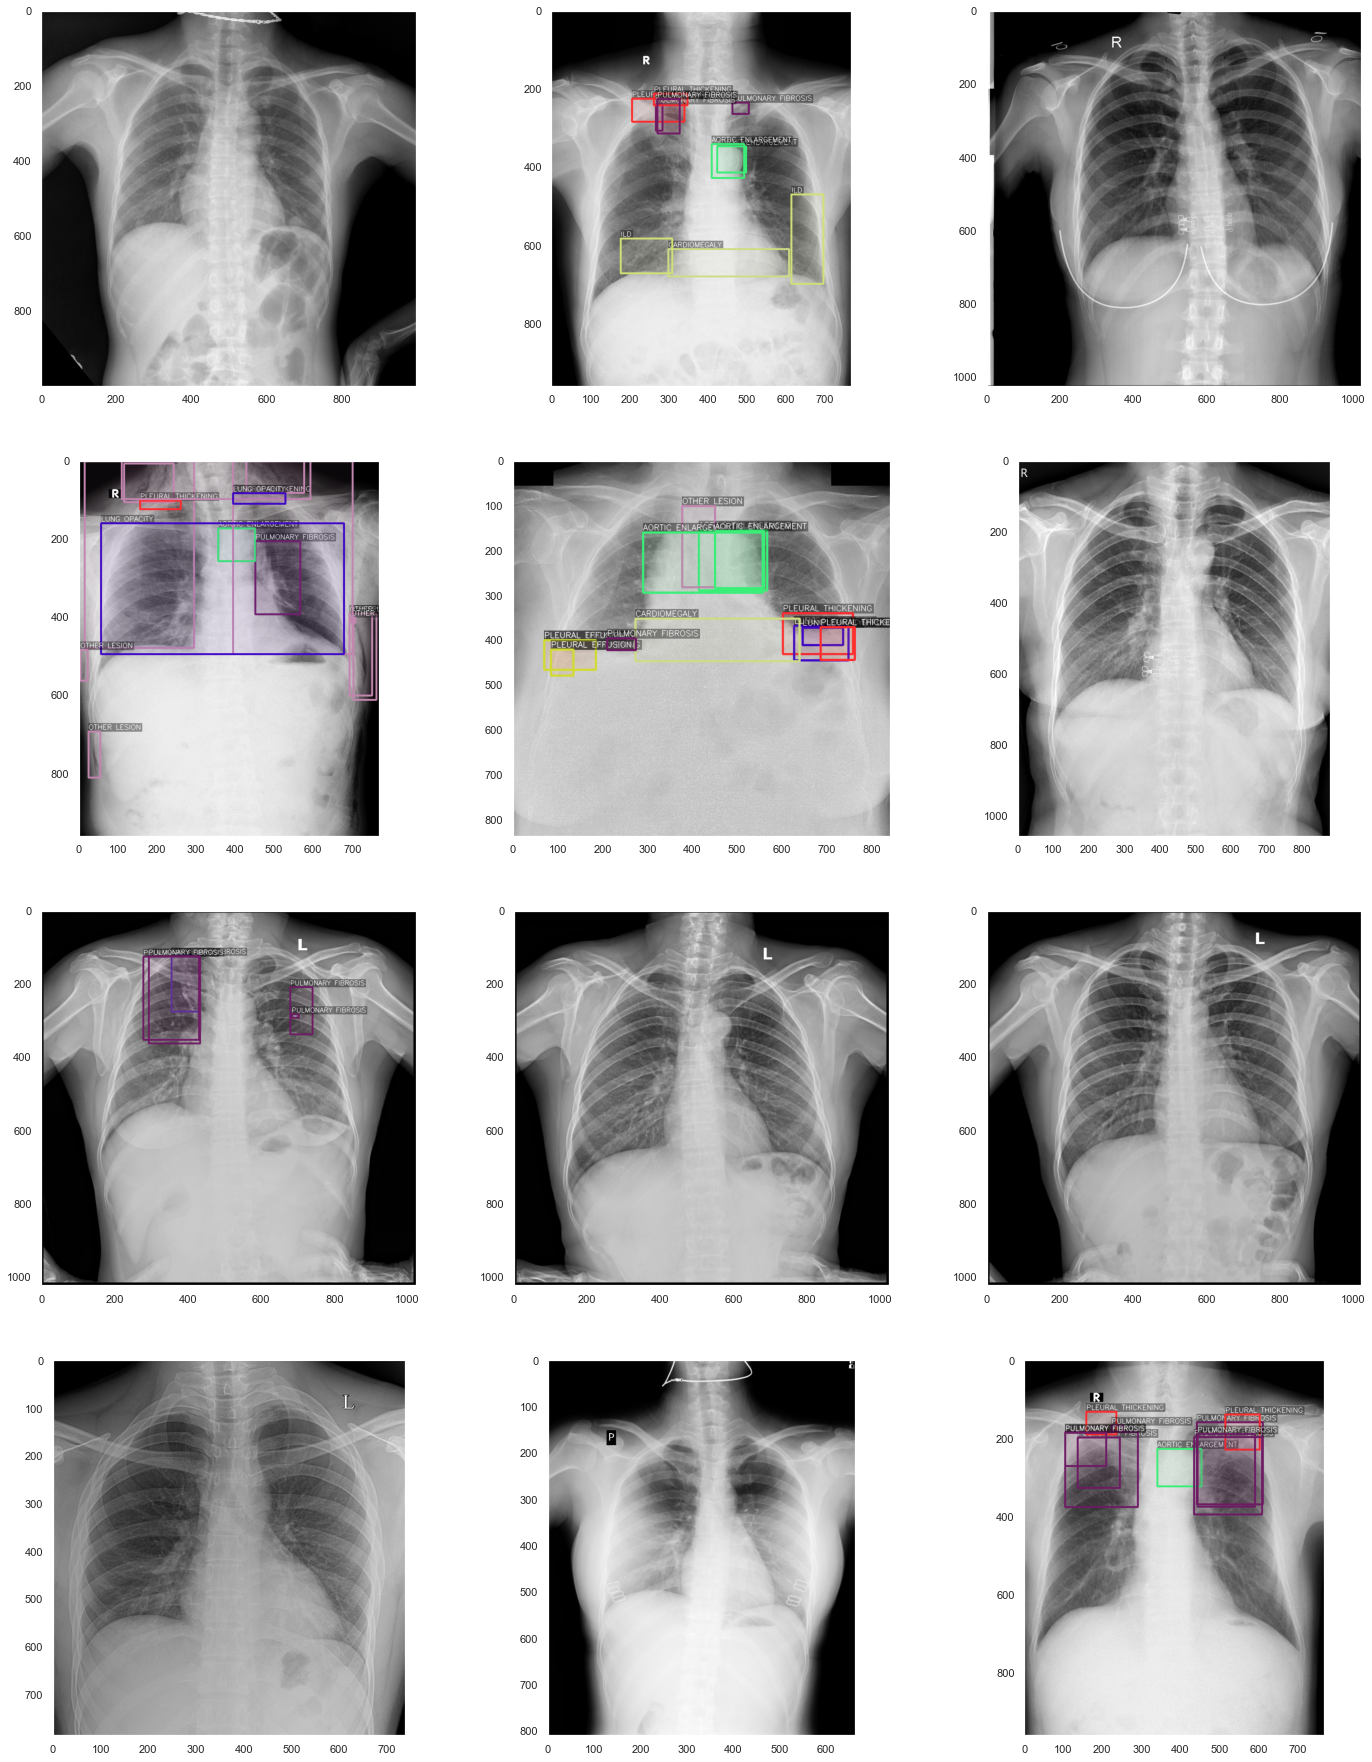

In [42]:
plot_multi_imgs(viz_images, cols = 3, size = 8)

+ Ratio of picture 4

In [43]:
for img_path in tqdm(imgs_path[4:5], total =len(imgs_path[4:5])):
  img_array = cv2.imread(img_path)
  h, w, _ = img_array.shape
  ratio = w/h
print(ratio)

  0%|          | 0/1 [00:00<?, ?it/s]

0.8


+ ration of picture 11

In [44]:
for img_path in tqdm(imgs_path[11:12], total =len(imgs_path[11:12])):
  img_array = cv2.imread(img_path)
  h, w, _ = img_array.shape
  ratio = w/h
print(ratio)

  0%|          | 0/1 [00:00<?, ?it/s]

1.0


+ Let's explore the ration of image's width and height

In [48]:
def get_ratio_w_h(df):
  ratio = df["image_width"] / df["image_height"]
  return ratio

In [49]:
df_train_img_size["ratio_w_h"]  =df_train_img_size.apply(get_ratio_w_h, axis = 1)

In [50]:
df_train_img_size.head()

image_id  image_height  image_width  \
0  000434271f63a053c4128a0ba6352c7f           945          778   
1  00053190460d56c53cc3e57321387478           810          664   
2  0005e8e3701dfb1dd93d53e2ff537b6e          1024         1024   
3  0006e0a85696f6bb578e84fafa9a5607          1000         1000   
4  0007d316f756b3fa0baea2ff514ce945           960          768   

                                          image_path  ratio_w_h  
0  ..\..\Dataset\train\train\000434271f63a053c412...   0.823280  
1  ..\..\Dataset\train\train\00053190460d56c53cc3...   0.819753  
2  ..\..\Dataset\train\train\0005e8e3701dfb1dd93d...   1.000000  
3  ..\..\Dataset\train\train\0006e0a85696f6bb578e...   1.000000  
4  ..\..\Dataset\train\train\0007d316f756b3fa0bae...   0.800000

In [54]:
# mode
statistics.mode(df_train_img_size["ratio_w_h"].values)

0.8197530864197531

In [55]:
df_train_img_size[["ratio_w_h"]].describe()

ratio_w_h
count  15000.000000
mean       0.876927
std        0.083611
min        0.627641
25%        0.819753
50%        0.831516
75%        0.938538
max        1.580247

In [56]:
x = df_train_img_size[["ratio_w_h"]].describe()
df = pd.DataFrame({"mean":x.iloc[1].values[0], 
                   "std": x.iloc[2].values[0], 
                   "min": x.iloc[3].values[0], 
                   "25%": x.iloc[4].values[0], 
                   "50%": x.iloc[5].values[0], 
                   "75%": x.iloc[6].values[0], 
                   "max": x.iloc[7].values[0]}, index = [0])
df

mean       std       min       25%       50%       75%       max
0  0.876927  0.083611  0.627641  0.819753  0.831516  0.938538  1.580247

<AxesSubplot:xlabel='ratio_w_h', ylabel='Density'>

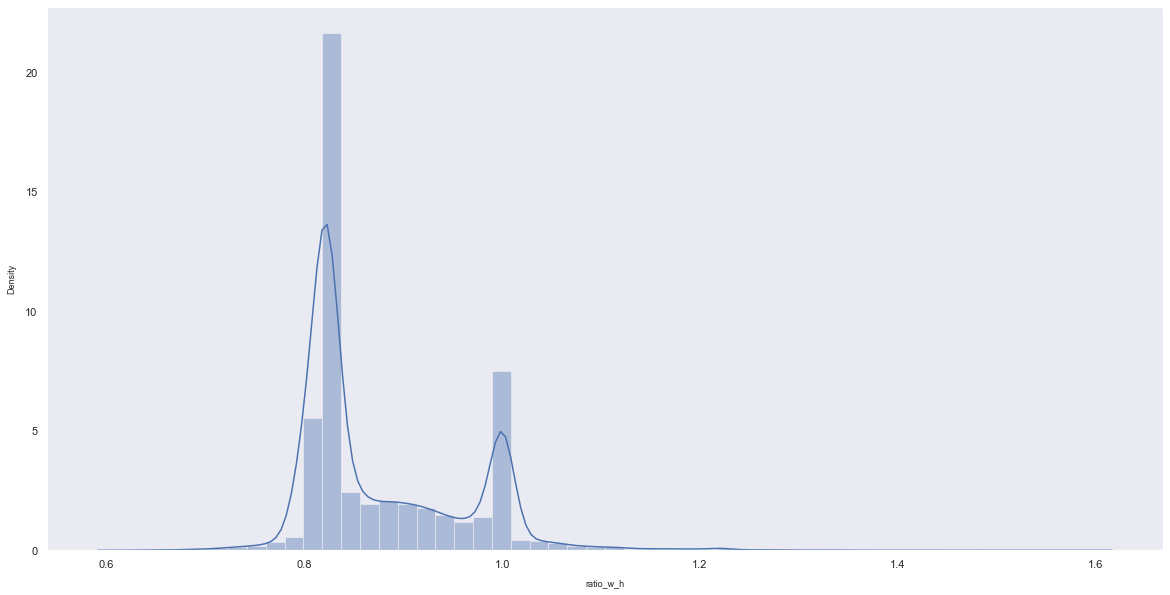

In [59]:
plt.figure(figsize = (20,10))
sns.distplot(a = df_train_img_size["ratio_w_h"], bins = 50)

In [61]:
# number of image with ration = 1
num_ratio_1 = len(df_train_img_size[df_train_img_size.ratio_w_h == 1])
percentage_ratio_1 = (num_ratio_1/15000) *100
print(f"num_ratio_1 = {num_ratio_1} with percentage = {percentage_ratio_1}")

num_ratio_1 = 1951 with percentage = 13.006666666666666


In [62]:
# number of image with ration > 1
num_ratio_greater_1 = len(df_train_img_size[df_train_img_size.ratio_w_h > 1])
percentage_ratio_greater_1 = (num_ratio_greater_1/15000) *100
print(f"num_ratio_greater_1 = {num_ratio_greater_1} with percentage = {percentage_ratio_greater_1}")

num_ratio_greater_1 = 676 with percentage = 4.506666666666667


In [63]:
# number of image with ration < 1
num_ratio_smaller_1 = len(df_train_img_size[df_train_img_size.ratio_w_h < 1])
percentage_ratio_smaller_1 = (num_ratio_smaller_1/15000) *100
print(f"num_ratio_greater_1 = {num_ratio_smaller_1} with percentage = {percentage_ratio_smaller_1}")

num_ratio_greater_1 = 12373 with percentage = 82.48666666666666


### 1.1 Explore ratio < 1

In [64]:
x = df_train_img_size[df_train_img_size.ratio_w_h < 1]
imgs_path = x.image_path.values
thickness =  3
viz_images_smaler_1 = []
for img_path in tqdm(imgs_path[:9], total =len(imgs_path[:9])):
  img_array = cv2.imread(img_path)
  img_copy = img_array.copy()
  img_id = Path(img_path).stem
  print(img_id)
  boxes_label = df_train.loc[df_train["image_id"] == img_id,["class_id"]].values.squeeze()
  boxes_location = df_train.loc[df_train["image_id"] == img_id,["x_min", "y_min", "x_max", "y_max"]].values  
  print(f"boxes_label \n{boxes_label}")
  
  if len(boxes_location) == 1:
    color = label2color[boxes_label]
    img_copy = draw_bbox(img_copy, 
                    list(np.int_(boxes_location.squeeze())), 
                    GetKey(boxes_label), 
                    color, 
                    thickness = thickness)
  else:
    for label_id, box in zip(boxes_label, boxes_location):
      color = label2color[label_id]
      img_copy = draw_bbox(img_copy, 
                      list(np.int_(box)), 
                      GetKey(label_id), 
                      color, 
                      thickness = thickness)
  viz_images_smaler_1.append(img_copy)

  0%|          | 0/9 [00:00<?, ?it/s]

000434271f63a053c4128a0ba6352c7f
boxes_label 
[14 14 14]
00053190460d56c53cc3e57321387478
boxes_label 
[14 14 14]
0007d316f756b3fa0baea2ff514ce945
boxes_label 
[13 11  3 11 13  0  5  5  0 11 13]
000d68e42b71d3eac10ccc077aba07c1
boxes_label 
[ 9  9  9  9 11 13 11  0  9  9  7  9  9  9  7  9]
00176f7e1b1cb835123f95960b9a9efd
boxes_label 
[14 14 14]
0032c6091dc8f1b1245fc2f5f45458fa
boxes_label 
[14 14 14]
003cfe5ce5c0ec5163138eb3b740e328
boxes_label 
[14 14 14]
0046f681f078851293c4e710c4466058
boxes_label 
[ 0  6 13 11 13 13 13 11 13 13 13]
004d2bc2111d639f5e8441ced52d55cb
boxes_label 
[14 14 14]


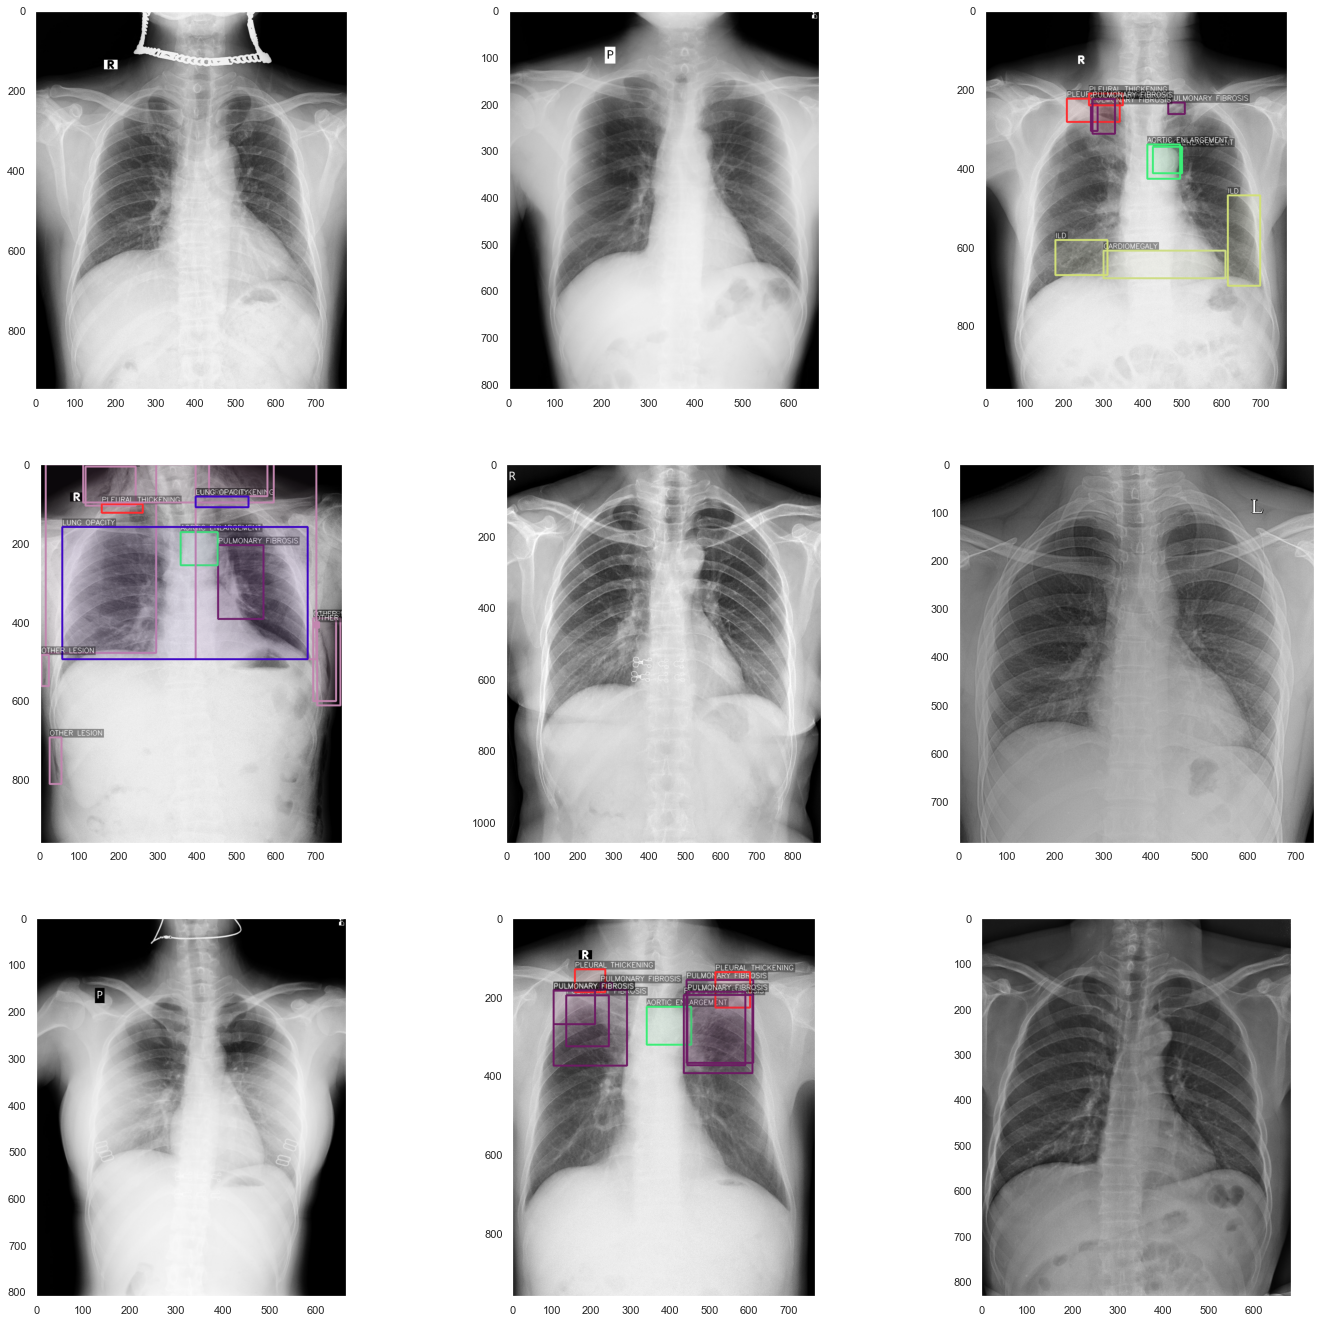

In [65]:
plot_multi_imgs(viz_images_smaler_1, cols = 3, size = 8)

### 1.2 Explore ratio = 1

In [66]:
x = df_train_img_size[df_train_img_size.ratio_w_h == 1]
imgs_path = x.image_path.values
thickness =  3
viz_images_1 = []
for img_path in tqdm(imgs_path[:9], total =len(imgs_path[:9])):
  img_array = cv2.imread(img_path)
  img_copy = img_array.copy()
  img_id = Path(img_path).stem
  print(img_id)
  boxes_label = df_train.loc[df_train["image_id"] == img_id,["class_id"]].values.squeeze()
  boxes_location = df_train.loc[df_train["image_id"] == img_id,["x_min", "y_min", "x_max", "y_max"]].values  
  print(f"boxes_label \n{boxes_label}")
  
  if len(boxes_location) == 1:
    color = label2color[boxes_label]
    img_copy = draw_bbox(img_copy, 
                    list(np.int_(boxes_location.squeeze())), 
                    GetKey(boxes_label), 
                    color, 
                    thickness = thickness)
  else:
    for label_id, box in zip(boxes_label, boxes_location):
      color = label2color[label_id]
      img_copy = draw_bbox(img_copy, 
                      list(np.int_(box)), 
                      GetKey(label_id), 
                      color, 
                      thickness = thickness)
  viz_images_1.append(img_copy)

  0%|          | 0/9 [00:00<?, ?it/s]

0005e8e3701dfb1dd93d53e2ff537b6e
boxes_label 
[7 8 6 7 4]
0006e0a85696f6bb578e84fafa9a5607
boxes_label 
[14 14 14]
000ae00eb3942d27e0b97903dd563a6e
boxes_label 
[14 14 14]
001d127bad87592efe45a5c7678f8b8d
boxes_label 
[13 13  2 13 13 13]
0021df30f3fddef551eb3df4354b1d06
boxes_label 
[14 14 14]
00291f7aff0123ea76a59998effef229
boxes_label 
[14 14 14]
006501b11e04aec2d403177b9ae0f34c
boxes_label 
[14 14 14]
006e5626f560c1a2a74f953d71f16c11
boxes_label 
[14 14 14]
00948e3e6acc03044af454fb9700ca60
boxes_label 
[14 14 14]


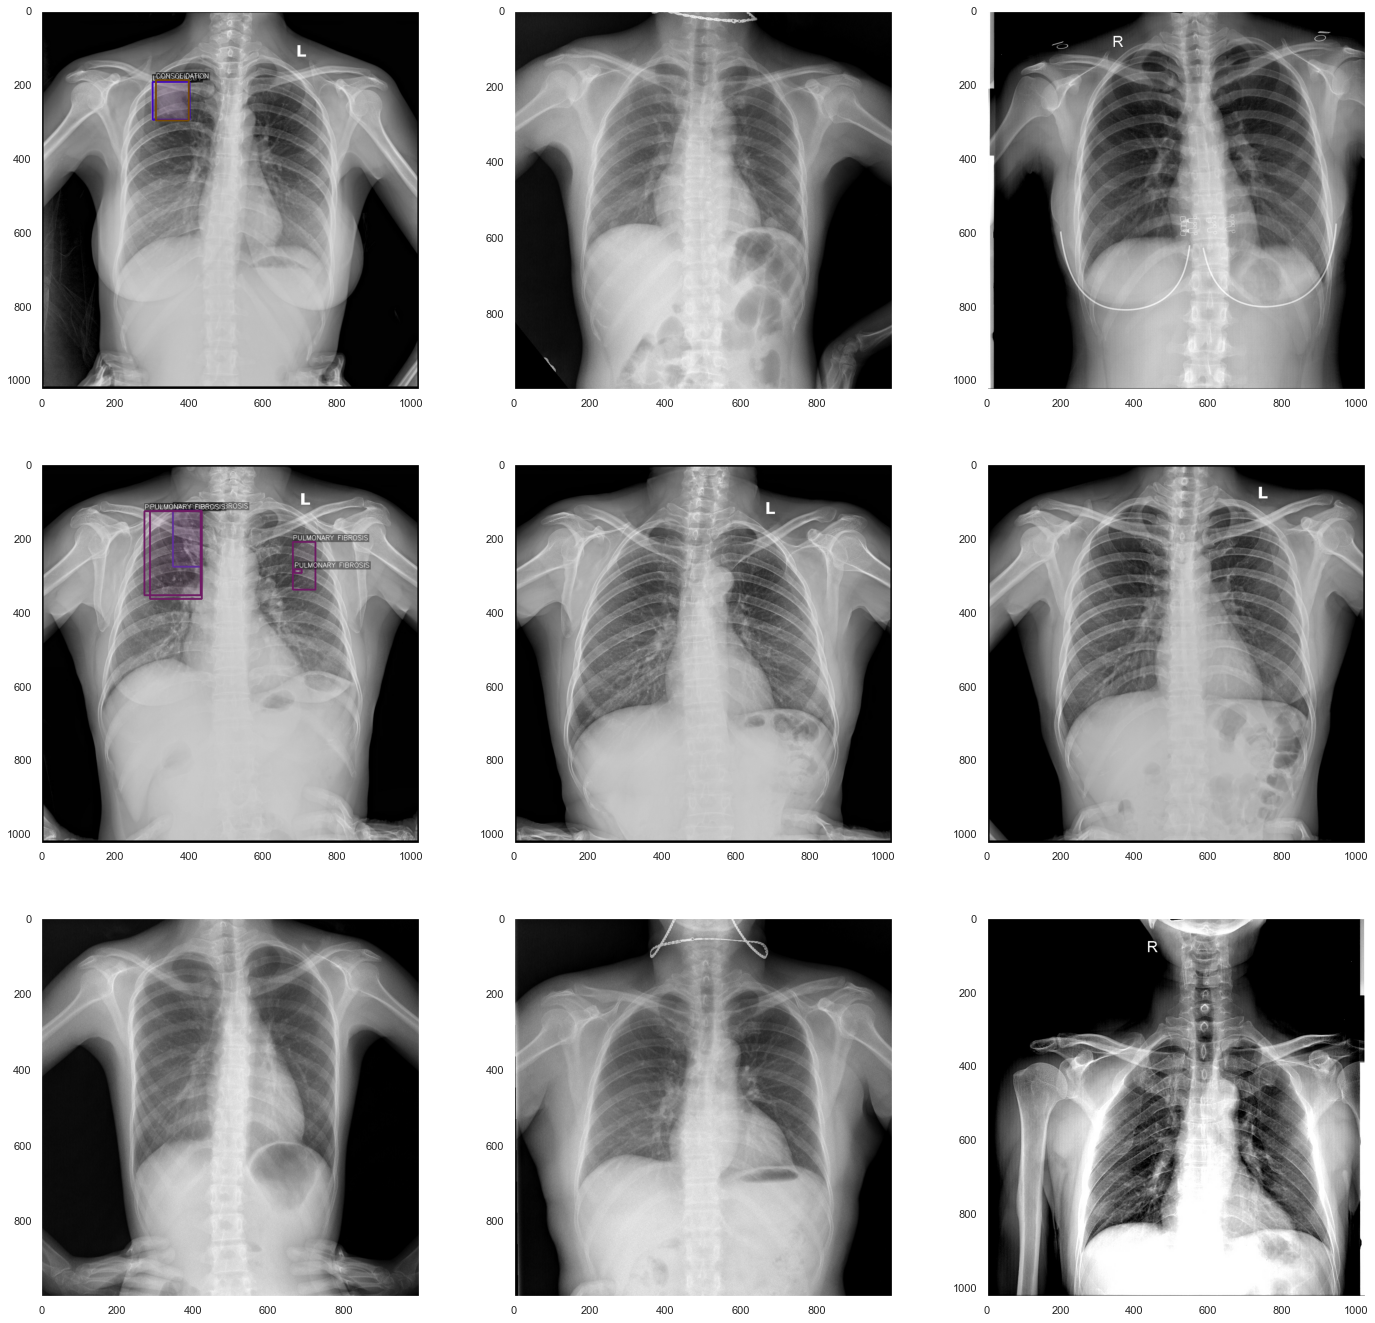

In [67]:
plot_multi_imgs(viz_images_1, cols = 3, size = 8)

### 1.3 Explore ratio > 1

In [69]:
x = df_train_img_size[df_train_img_size.ratio_w_h > 1]
imgs_path = x.image_path.values
thickness =  3
viz_images_greater_1 = []
for img_path in tqdm(imgs_path[:9], total =len(imgs_path[:9])):
  img_array = cv2.imread(img_path)
  img_copy = img_array.copy()
  img_id = Path(img_path).stem
  print(img_id)
  boxes_label = df_train.loc[df_train["image_id"] == img_id,["class_id"]].values.squeeze()
  boxes_location = df_train.loc[df_train["image_id"] == img_id,["x_min", "y_min", "x_max", "y_max"]].values  
  print(f"boxes_label \n{boxes_label}")
  
  if len(boxes_location) == 1:
    color = label2color[boxes_label]
    img_copy = draw_bbox(img_copy, 
                    list(np.int_(boxes_location.squeeze())), 
                    GetKey(boxes_label), 
                    color, 
                    thickness = thickness)
  else:
    for label_id, box in zip(boxes_label, boxes_location):
      color = label2color[label_id]
      img_copy = draw_bbox(img_copy, 
                      list(np.int_(box)), 
                      GetKey(label_id), 
                      color, 
                      thickness = thickness)
  viz_images_greater_1.append(img_copy)

  0%|          | 0/9 [00:00<?, ?it/s]

00150343289f317a0ad5629d5b7d9ef9
boxes_label 
[11  0 11 13 10 10 11  9  0  7 10  7 10  3 13 11  0]
01014f8d2c30a1fabc30f28e7de53467
boxes_label 
[14 14 14]
015bf89fc34cde9fafe7c79366fecee7
boxes_label 
[14 14 14]
01c2b9fcb0384c84648ed76c736552a8
boxes_label 
[3 3 9 3 0 0 0]
024f9140bd829c346fc91fcf4009d251
boxes_label 
[ 7  7 11 11 11 11  7  7  8  7 11  7 11 11 11  7  7 11  8 11 11  7  8]
032c81fae916e932002387494a7d7c7b
boxes_label 
[14 14 14]
0339aac16e3dd93ee397315a224147a6
boxes_label 
[13 13 13]
03ec9ca738f579b956cb4af13efa155a
boxes_label 
[14 14 14]
0452d38f45e4e79f91821e88bb812608
boxes_label 
[0 0 3 3 3 0]


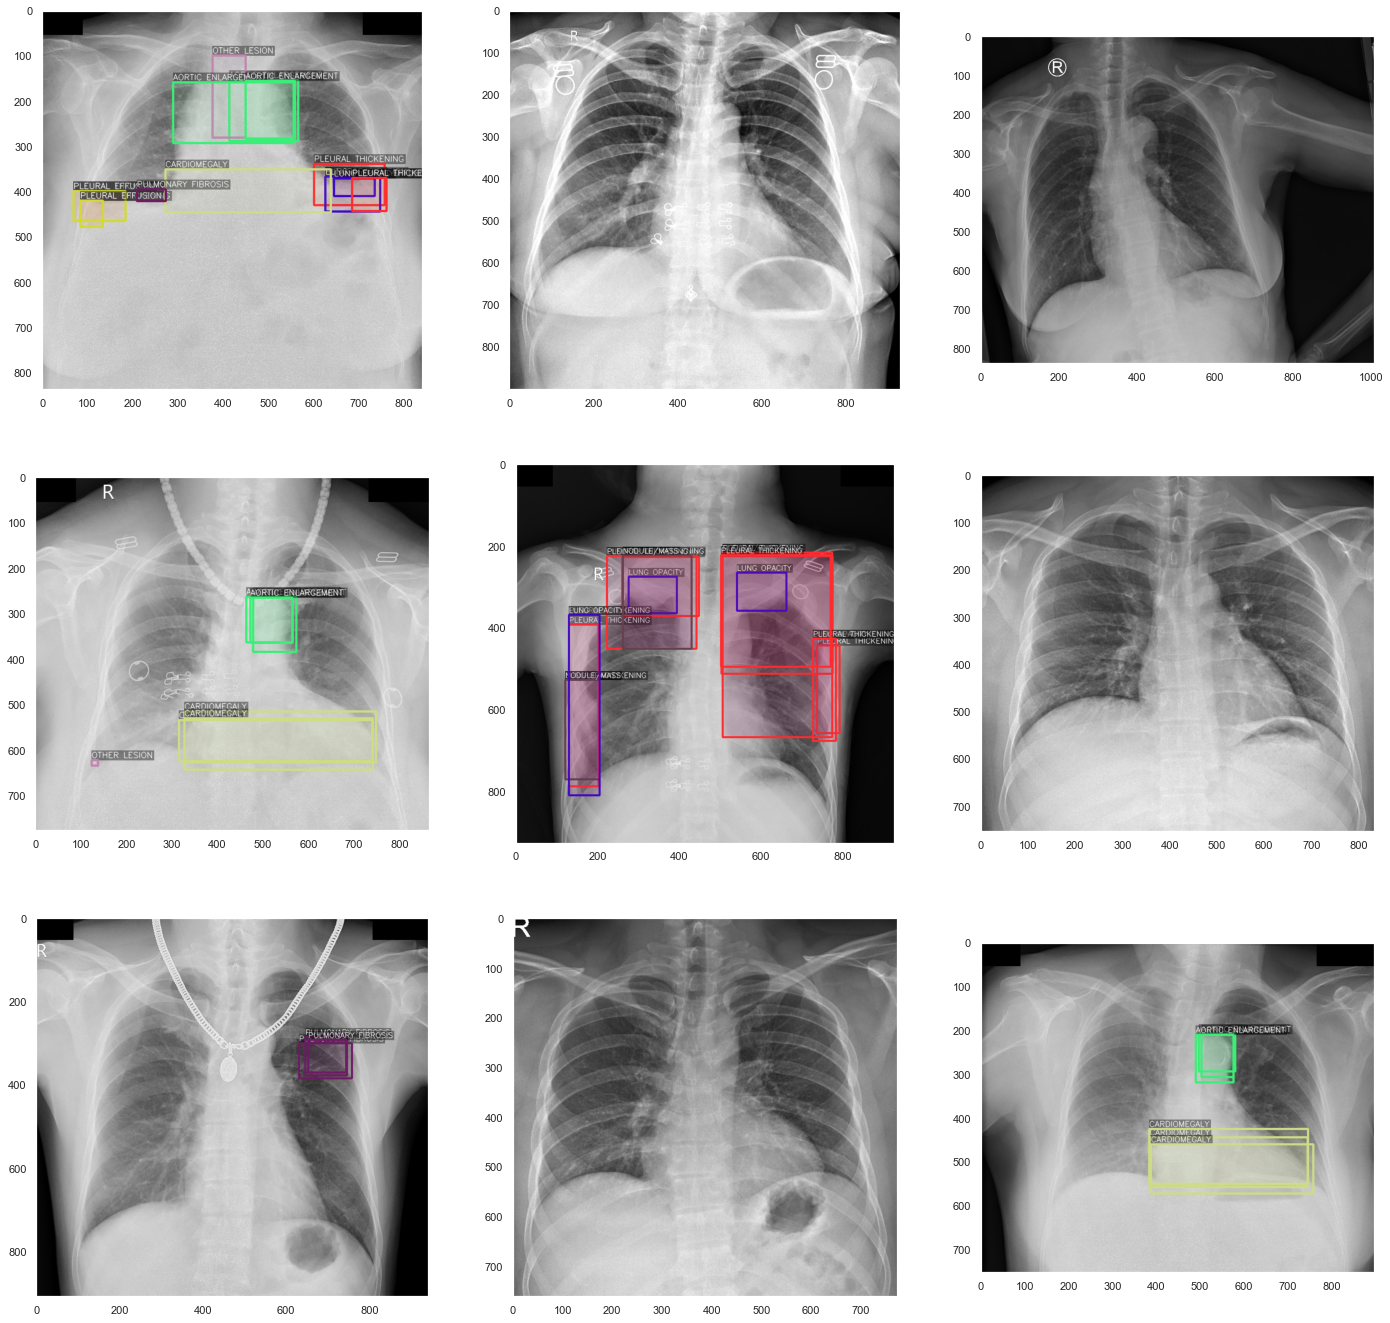

In [70]:
plot_multi_imgs(viz_images_greater_1, cols = 3, size = 8)